In [2]:
# import: external libraries
import torch
import torchshow as ts
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from PIL import Image
from tqdm.notebook import tqdm

print(f"cuda: {torch.cuda.is_available()}")

# import: solutions from the lessons
from underwater_imagery.models.encoder_decoder import Encoder, Decoder, EncoderDecoder

# import: own modules
from underwater_imagery.data.uim_dataset import UIMDataset
from underwater_imagery.data.constants import TRAIN_PATH, CLASSES, SHAPE
from underwater_imagery.data.transf import resize_transf, resize_normalize_transf
print(SHAPE)

cuda: True
(240, 320)


In [3]:
batch_size = 16

ds = UIMDataset(
    TRAIN_PATH, 
    CLASSES, 
    SHAPE,
    resize_normalize_transf,
    resize_transf
)

ds_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
)

In [3]:
data = next(iter(ds_loader))
images, masks, labels = data

In [4]:
from underwater_imagery.models.suim_net.suim_net import SuimNet

suim_net_cpu = SuimNet(
    classes=CLASSES,
    device='cpu'
)

pred = suim_net_cpu.forward(images)
assert pred.shape[-2: ] == images.shape[-2: ]

In [6]:
import torch.optim as optim

torch.manual_seed(123)

# Parameters
num_epochs = 50
device = 'cuda'

# create model
suim_net = SuimNet(
    classes=CLASSES,
    device=device
)


# Create Loss-Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(suim_net.parameters())

pbar = tqdm(total=num_epochs * len(ds_loader))

step = 0
for epoch in range(0, num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(ds_loader):
        
        images, label_masks, label_images = data
        images = images.to(device)
        label_masks = label_masks.to(device)
        label_images = label_images.to(device)
        
        # Forward-Pass
        optimizer.zero_grad()
        logits = suim_net(images)
        loss = criterion(logits, label_masks)
        
        # Optimize
        loss.backward()
        optimizer.step()
        
        # Calculate Pixel-Accuracy
        probs = F.softmax(logits, dim=1)
        pred = probs.argmax(dim=(1), keepdim=True)
        pixel_acc = (label_images == pred).to(torch.float).mean()

        # print statistics
        running_loss += loss.item()
        running_acc += pixel_acc
        step += 1
        print_every = 10
        if (i % print_every) == (print_every - 1):
            desc = f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_every:.3f} acc: {running_acc / print_every:.3f}'
            _ = pbar.update(print_every)
            _ = pbar.set_description(desc)
            running_loss = 0.0
            running_acc = 0.0
pbar.close()

print('Finished Training')
suim_path = f"suim_net_epoch{num_epochs}.pth"
torch.save(suim_net, suim_path)

  0%|          | 0/4800 [00:00<?, ?it/s]

Finished Training


In [6]:
suim_loaded = torch.load("suim_net_epoch50.pth")
suim_loaded.eval()
print("model loaded")

model loaded


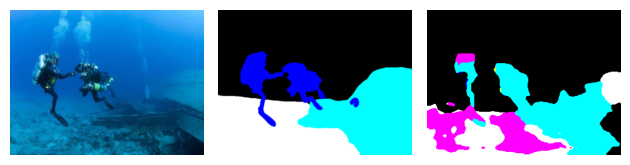

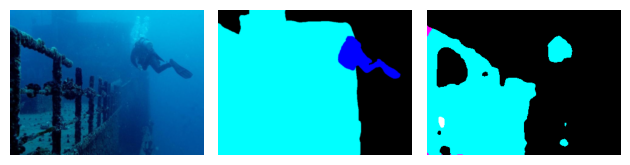

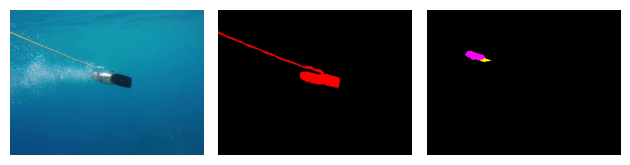

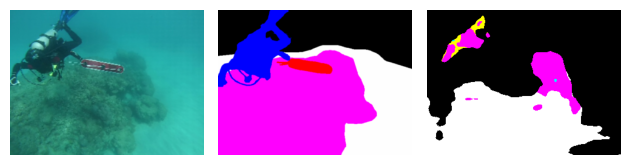

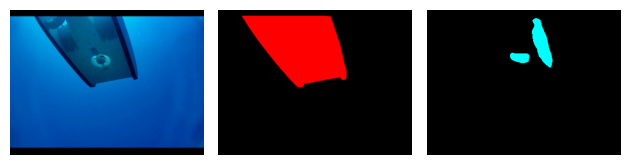

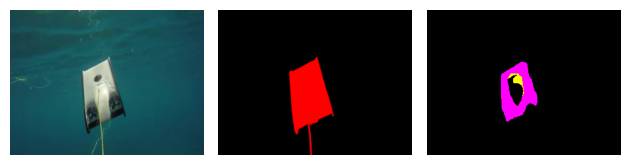

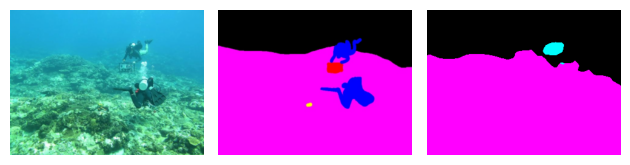

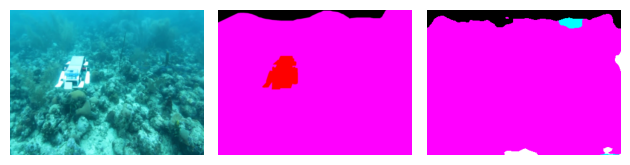

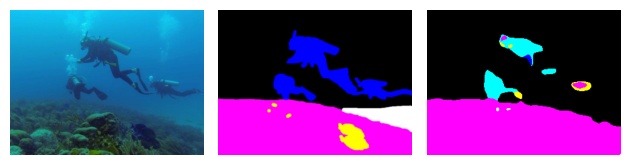

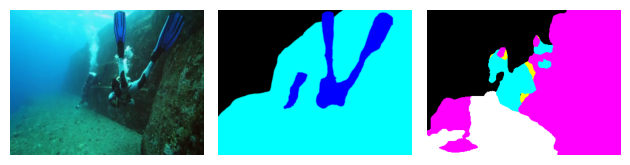

In [7]:
from underwater_imagery.data.transf import pred_to_label
for i in range(10):
    images, _, label_images = ds[i]
    images_gpu = images.unsqueeze(0).to('cuda')
    logits = suim_loaded(images_gpu)
    probs = F.softmax(logits, dim=1)[0]
    pred = probs.argmax(dim=(0), keepdim=True)
    pred_label = pred_to_label(pred) 
    ts.show([images, label_images, pred_label])